# This notebook demonstrates how to use Apache Arrow Flight SQL to query InfluxDB Cloud, Pandas to analyze the data, and matplotlib to visualize it.
## Note: this data has a large gap in the set. This is included to show you how to d

In [1]:
# 1. Import dependencies. 
from flightsql import FlightSQLClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS

# 2. Gather authentication credentials. 
token = "xxx"
url = "https://us-east-1-1.aws.cloud2.influxdata.com/"
org = "xxx"
bucket = "anais-iox"

# 3. Instantiate the FlightSQL Client
client = FlightSQLClient(host='us-east-1-1.aws.cloud2.influxdata.com',
                        token=token,
                        metadata={'bucket-name': 'anais-iox'},
                        features={'metadata-reflection': 'true'})

# 4. Execute a query against InfluxDB's Flight SQL endpoint. Here we are querying for all of our data.                         
query = client.execute("SELECT * FROM \"airSensors\"")

# 5. Create reader to consume result
reader = client.do_get(query.endpoints[0].ticket)

# 6. Read all data into a pyarrow.Table
Table = reader.read_all()

# 7. Convert to Pandas DataFrame
df = Table.to_pandas()
df = df.sort_values(by="time")
df.head(20) 


,co,humidity,sensor_id,temperature,time
0,0.517422,35.139987,TLM0100,71.170208,2023-02-01 18:34:31
361,0.484613,34.874626,TLM0101,71.802606,2023-02-01 18:34:31
2527,0.394477,35.948833,TLM0203,74.779119,2023-02-01 18:34:31
722,0.513511,34.860303,TLM0102,72.012782,2023-02-01 18:34:31
2166,0.510674,35.691850,TLM0202,75.312108,2023-02-01 18:34:31
1805,0.506245,35.232817,TLM0201,74.045357,2023-02-01 18:34:31
1444,0.489873,35.769058,TLM0200,73.560425,2023-02-01 18:34:31
1083,0.415399,35.164551,TLM0103,71.340827,2023-02-01 18:34:31
723,0.517580,34.855599,TLM0102,72.055388,2023-02-01 18:34:41
1,0.530448,35.151335,TLM0100,71.180480,2023-02-01 18:34:41


In [3]:
# downsample with Pandas DataFrames. Here we use the groupby function with the resample 
# function to group by sensor id and then calculate the mean over 5 min intervals. 
# use the dropna() function to drop empty windows where there are gaps in the data. 
df_mean = df.groupby(by=["sensor_id"]).resample('10min', on='time').mean().dropna() 
# create a copy of the downsampled data so we can write it back to InfluxDB Cloud powered by IOx. 
df_write = df_mean.reset_index()
df_mean


co   humidity  temperature
sensor_id time                                                 
TLM0100   2023-02-01 18:30:00  0.574546  35.266605    71.171200
          2023-02-01 18:40:00  0.569610  35.358244    71.333793
          2023-02-01 18:50:00  0.516955  35.441879    71.289883
          2023-02-01 19:00:00  0.462129  35.193253    71.519450
          2023-02-01 19:10:00  0.416039  35.143414    71.556587
...                                 ...        ...          ...
TLM0203   2023-02-03 22:50:00  0.242336  36.507586    75.153940
          2023-02-03 23:00:00  0.273699  36.562608    75.117751
          2023-02-03 23:10:00  0.258480  36.510316    74.792649
          2023-02-03 23:20:00  0.292327  36.537911    74.554340
          2023-02-03 23:30:00  0.354416  36.521472    74.556355

[152 rows x 3 columns]

<AxesSubplot:xlabel='time'>

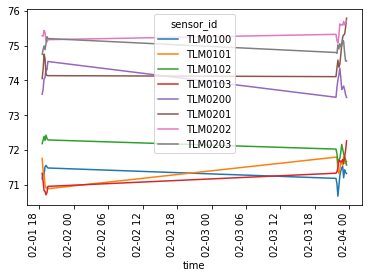

In [4]:
# If we just use matplotlib then we have to pivot our data in order to plot all of the sensors. There's also this large gap in our data. It would be better if we didn't graph the gap. The formating isn't great either. 
df_mean.reset_index().pivot(index='time', columns='sensor_id', values='temperature').plot(rot=90)

In [5]:
# Convert the time object to a string to handle the gap. 
df_mean.reset_index('sensor_id', inplace=True)
df_mean.index = df_mean.index.map(str)

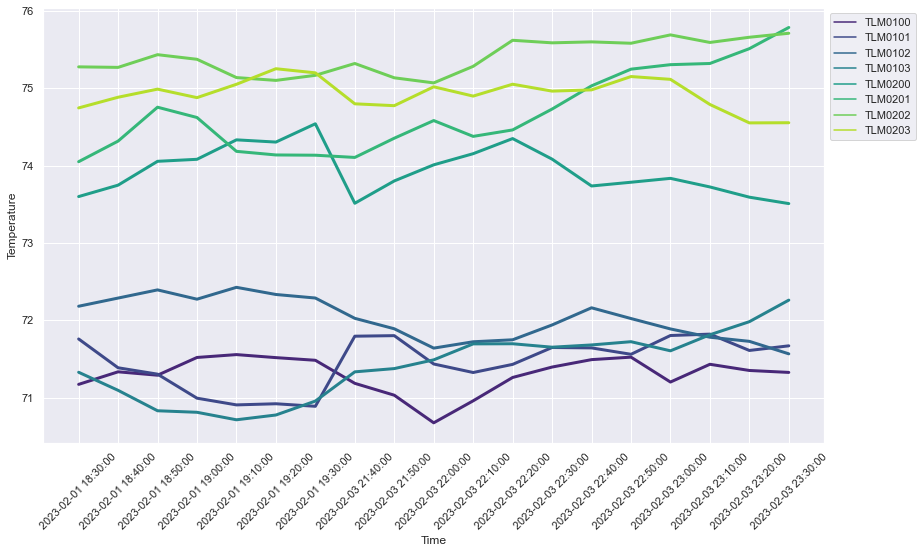

In [6]:
# Make a plot with seaborn instead to make the visualization stronger by moving the labels, pivoting the x-axis values, and removing the gap. 
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=df_mean.reset_index(), x ='time', y = 'temperature',
                  hue='sensor_id', palette='viridis',
                  legend='full', lw=3)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.show()

In [7]:
# write data back to InfluxDB Cloud powered by IOx
client = InfluxDBClient(url=url, token=token, org=org)
client.write_api(write_options=SYNCHRONOUS).write(bucket=bucket,
               record=df_write,
               data_frame_measurement_name="mean_downsampled",
               data_frame_timestamp_column='time',
               data_frame_tag_columns=['sensor_id'])